In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import math
import pims
import cv2
from scipy import interpolate
from scipy.signal import savgol_filter
import skimage.filters as sk_fil
import imutils
from skimage.transform import rotate
import sys
sys.path.insert(0, '/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/')
import myAnalyses.lowmag_analysis_OSS as dio

DEFINE FILE PATHS

In [7]:

#path = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Data/buckling_raw/'
path = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Data/filamentsToAnalyse/23-12-06_2_FilamentD_345_985_pos1_stabilised_10sec/'
#path = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Data/04-08-2022/'

path_to_image_stack = path + r'*.tif'

base = '23-12-06_2_FilamentE_450_1555'
#base = 'buckling'

#other file names
saveFile_image = base+'.png'
saveFile_pos_Speed = base+'_1.png'
saveFileHist = base+r'_dwelltime.png'
saveFilamentLength = base+r'_filamentLength.png'
saveMyData= base+r'_data.csv'


DEFINE PARAMETERS FOR THE ANALYSIS

In [9]:

### ACQUISITION PARAMETERS - FIXED BY THE MICROSCOPY ###
#um_per_px = 1/1.198    #optoscope 10x obj.    
um_per_px = 1.61        #olympus x4 obj.
delta_t = 10 # seconds      

#### FILAMENT DETECTION PARAMAETERS - TO BE OPTIMISED FOR EACH MOVIE ###
#threshold for creating binary image, which the contour algorithm will use
#NOTE: the threshold coefficient should be experimented with here to get good contour detection
#change this parameter and explore effects in section 2 - do so, for a bunch of frames!
#coeffForThresh = 0.98 #decide a good coefficient. Values that usually work are 0.97, 1, or 1.1
coeffForThresh = 1

#spline parameters. This is for the spline algorithm, used in section 2 (and then 3)
#experiment with this parameter and check effects in section 2 - do so, for a bunch of frames!
#smooth_spline = 10.0 # smoothness parameter
smooth_spline = 15.0 # smoothness parameter
#k_order_spline = 1 # spline order
k_order_spline = 3 # spline order
nest = -1 # estimate of number of knots needed (-1 = maximal)

#filament orientation to use for fitting spline
# NOTE: we need to make sure that "EndA" is the left/bottom end (red)
#and "EndB" is the right/top end (blue)
#set following to true if you want to force use of NS orientation to ensure this.
#if set false, code will automatically decide with orientation to use based on which 
#gives a longer filament fit. Decide how to use, based on section 2 result
#basically, use True if filament is clearly NS and top end is to the left or straight up
forceUseNS = False

#sample frame to plot
frameid=12

### ANALYSIS PARAMETERS ###
#for setting below parameters. Need to get this from section 5 of the code below
maxSpeed  = 1

#speedthreshold is used for deciding state of ends (trailling, heading, or stopped). 
#NOTE: Decide threshold based on max speed calculated at the end of section 5. Use 90% of that
#NOTE: we use a rather high threshold, below which we don't assign state because filaments are
#slow. For these slow cases with 'undecided' state, we assign state from extrapolation from
#decided cases (see next section of the code)
speedthreshold_headTail_trackPoint = maxSpeed*0.6

#speedthreshold used for deciding dwelling stages
#NOTE: Decide threshold based on max speed calculated at the end of section 5. Use 10% of that
#ideally, we would like to detect so many dwell times (i.e. reversals) as we see in the movie
#and as indicated by position data. Check this by checking length of 'stopDurations' arrays.
#Speed data tends to be noisy, so we use smooth version
speedThreshold_DwellTime = maxSpeed*0.1 #um/sec

#smoothing range - larger the less noisy 
#NOTE: we prefer less noisy for dwell time calc. 
#More noisy (i.e. raw) speed data tends to break up reversals into several pieces, resulting in
#shorter dwell times. This is because speed profile has peaks in it. Overall, you can decide the right 
#amount of smoothing based on how many reversals (i.e. dwell times) you get and how many you see in the
#position data or the actual filament movie.
#following value seems to work well, but check for each filament
howsmooth = 20
poly_order = 3

0. LOAD TIMELAPSE, CHECK TYPE, NORMALISE INTENSITY, AND CHECK OUT INTENSITY DISTRUBITION FOR ONE FRAME

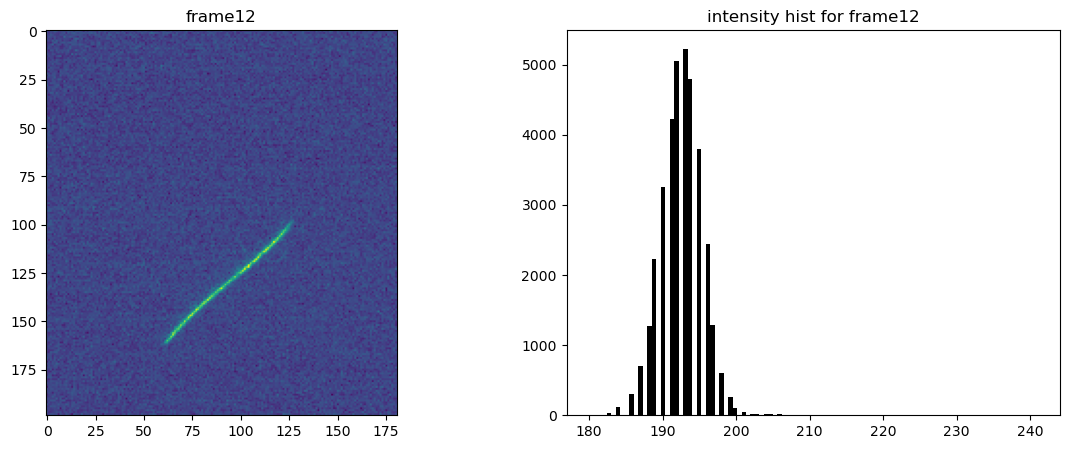

In [10]:

#open image stack
frames = pims.open(path_to_image_stack)

#convert image datatype, first to float to normalise and then to uint8
#first get max pixel value
k=0
maxPixel=0
for frame in frames:
    intPixel = max(frame.flat)
    if intPixel>maxPixel:
        maxPixel=intPixel
        frameID = k
    k=k+1

#maxPixelValue = np.iinfo(frames[120].dtype).max             #get max allowed pixel value
frames1 = pims.pipeline(lambda x: x.astype(np.float32))(frames) #convert to float32 first
frames2 = pims.pipeline(lambda x: x*(255/maxPixel))(frames1) #normalize to 0-255 range
frames3 = pims.pipeline(lambda x: x.astype(np.uint8))(frames2)  #convert to uint8 
frames = frames3

# Plot a test frame and show the histogram
fig, ax = plt.subplots(1,2, figsize=(14,5))
frame = frames[frameid]
#ax[0].imshow(frame, vmin=0, vmax=1, cmap='Reds')
ax[0].imshow(frame)
ax[0].set_title(str('frame'+str(frameid)))
n_0, bins_0, patches_0 = ax[1].hist(frame.flat, bins = 100, color='black')
ax[1].set_title(str('intensity hist for frame'+str(frameid)))
plt.show()
#frames3
#frame[10].dtype

1. USE MAX PROJECTION JUST TO DECIDE EXTREME POINTS OF THE MOVEMENT FOR DISTANCE CALCULATIONS

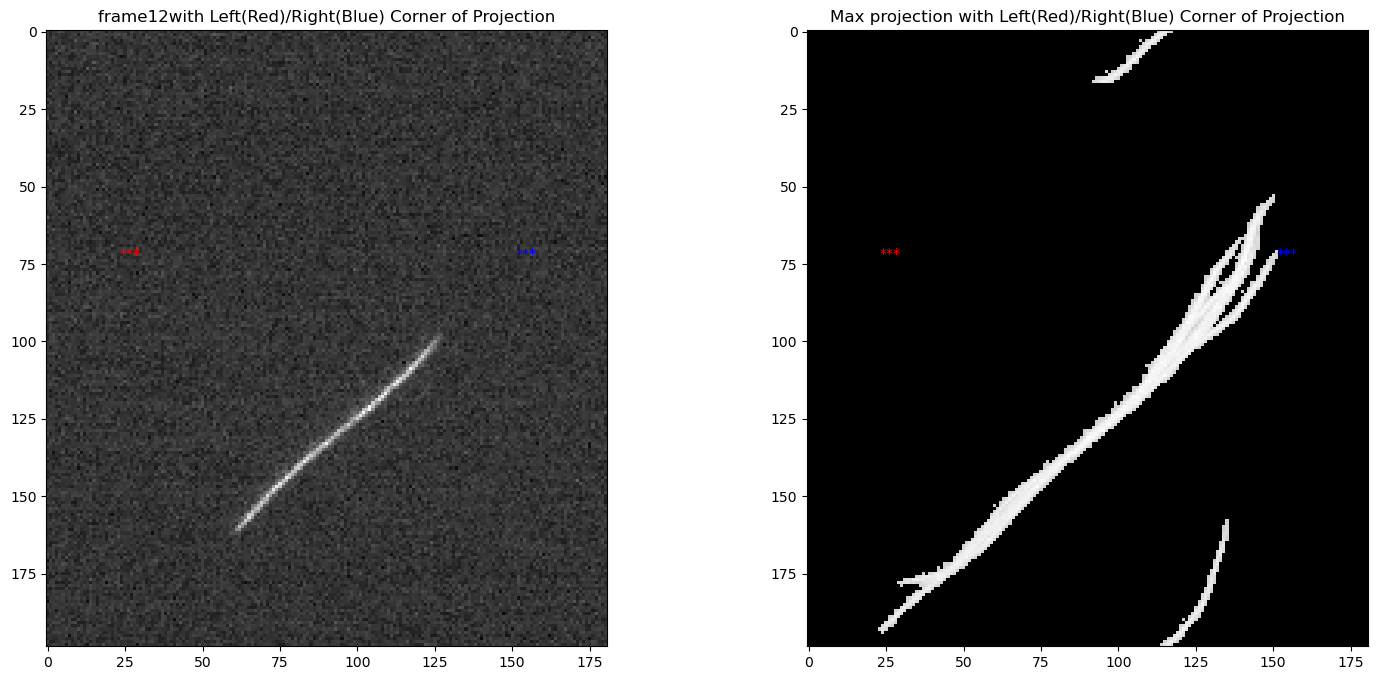

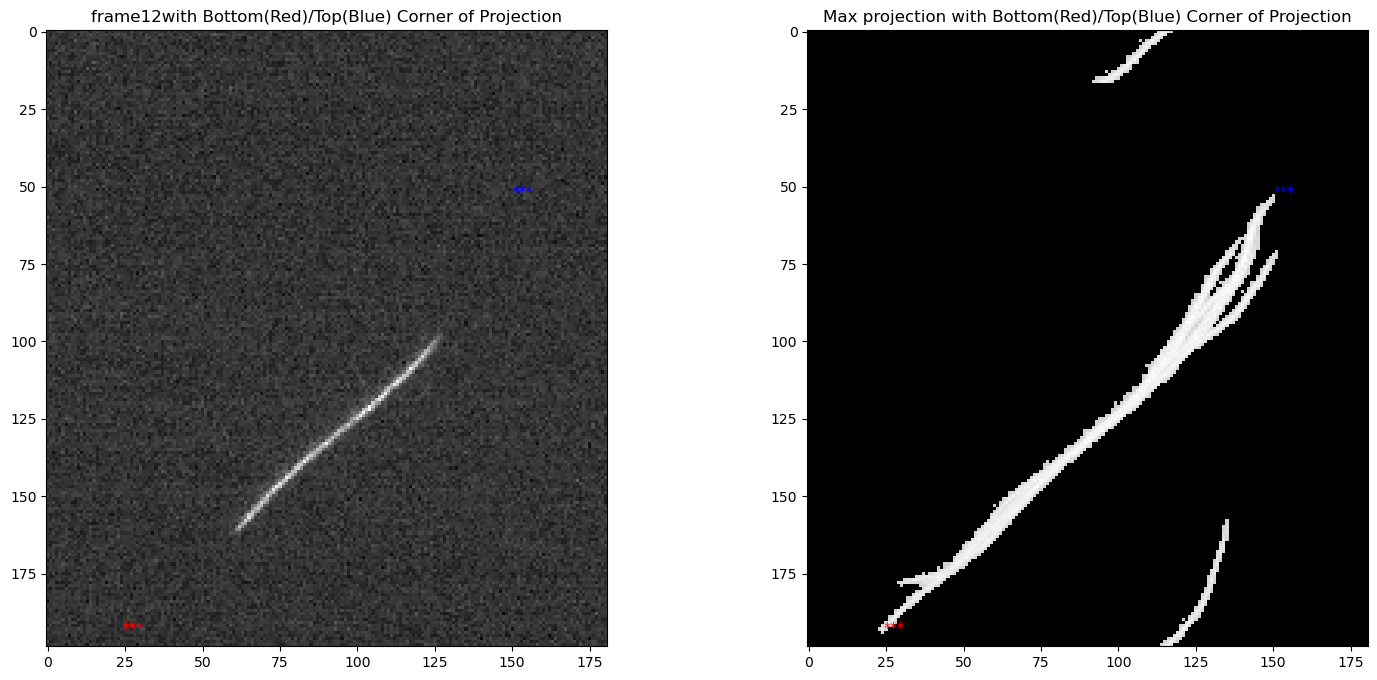

In [11]:
#the following is a max-projection of the timelapse, based on this: 
#https://stackoverflow.com/questions/48178916/maximum-intensity-projection-from-image-stack/52085463
IM_MAX= np.max(frames, axis=0)
thresh = sk_fil.threshold_yen(IM_MAX) 
binary = IM_MAX > (coeffForThresh*thresh)          #fneed to play with multiplier to get best performance!
IM_MAX2 = binary*IM_MAX

#find contours in the frame, to get the filament
contours = cv2.findContours(IM_MAX2,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)    #note that this finds all the contours
cnts = imutils.grab_contours(contours)                                                      #get all contours that are found
cnt = max(cnts, key=cv2.contourArea)                                                        #pick the countour with max area - most likely to be our guy
x1 = cnt[:,0,0]                                                                             #x and y coordinates of the contour
y1 = cnt[:,0,1]

#get the extreme ends of the contour
extLeft = tuple(cnt[cnt[:, :, 0].argmin()][0]) #smallest x-coordinate
extRight = tuple(cnt[cnt[:, :, 0].argmax()][0]) #largest x-coordinate
extTop = tuple(cnt[cnt[:, :, 1].argmin()][0]) #smallest y-coordinate
extBot = tuple(cnt[cnt[:, :, 1].argmax()][0]) ##largest y-coordinate
indexforRightCorner, indexforLeftCorner, indexforTopCorner, indexforBottomCorner = dio. get_indicesForCorners_OSS(cnt, extRight, extLeft, extTop, extBot)

#plot image, MAX PROJECTION, and corners
fig, ax = plt.subplots(1,2, figsize=(18,8))
ax[0].imshow(frame,cmap="gray")
ax[0].annotate('***',xy=(x1[indexforRightCorner],y1[indexforRightCorner]),color='blue')  #marking ends based on order of spline points
ax[0].annotate('***',xy=(x1[indexforLeftCorner],y1[indexforRightCorner]),color='red')
ax[0].set_title(str('frame'+str(frameid) + 'with Left(Red)/Right(Blue) Corner of Projection'))
ax[1].imshow(IM_MAX2,cmap="gray")
ax[1].annotate('***',xy=(x1[indexforRightCorner],y1[indexforRightCorner]),color='blue')  #marking ends based on order of spline points
ax[1].annotate('***',xy=(x1[indexforLeftCorner],y1[indexforRightCorner]),color='red')
ax[1].set_title(str('Max projection with Left(Red)/Right(Blue) Corner of Projection'))

#plot image, MAX PROJECTION, and corners
fig, ax = plt.subplots(1,2, figsize=(18,8))
ax[0].imshow(frame,cmap="gray")
ax[0].annotate('***',xy=(x1[indexforTopCorner],y1[indexforTopCorner]),color='blue')  #marking ends based on order of spline points
ax[0].annotate('***',xy=(x1[indexforBottomCorner],y1[indexforBottomCorner]),color='red')
ax[0].set_title(str('frame'+str(frameid) + 'with Bottom(Red)/Top(Blue) Corner of Projection'))
ax[1].imshow(IM_MAX2,cmap="gray")
ax[1].annotate('***',xy=(x1[indexforTopCorner],y1[indexforTopCorner]),color='blue')  #marking ends based on order of spline points
ax[1].annotate('***',xy=(x1[indexforBottomCorner],y1[indexforBottomCorner]),color='red')
ax[1].set_title(str('Max projection with Bottom(Red)/Top(Blue) Corner of Projection'))

### RECORD TRACK END POINTS AS THE CORRECT CORNERS OF THE PROJECTION ###
### NOTE: Adjust for each analysis!
trackEndPointA = np.array([x1[indexforBottomCorner],y1[indexforBottomCorner]])  #endA is red in subsequent analyses
#trackEndPointA = np.array([x1[indexforLeftCorner],y1[indexforLeftCorner]])  #endA is red in subsequent analyses
#trackEndPointB = np.array([x1[indexforRightCorner],y1[indexforRightCorner]])    #endB is blue in subsequent analyses
trackEndPointB = np.array([x1[indexforTopCorner],y1[indexforTopCorner]])    #endB is blue in subsequent analyses

2. TEST THAT SPLINE FITTING WORKS USING SINGLE FRAME.

(87.10230588238218, 86.91493435852396, 87.89567101344004, 87.43325502193497)

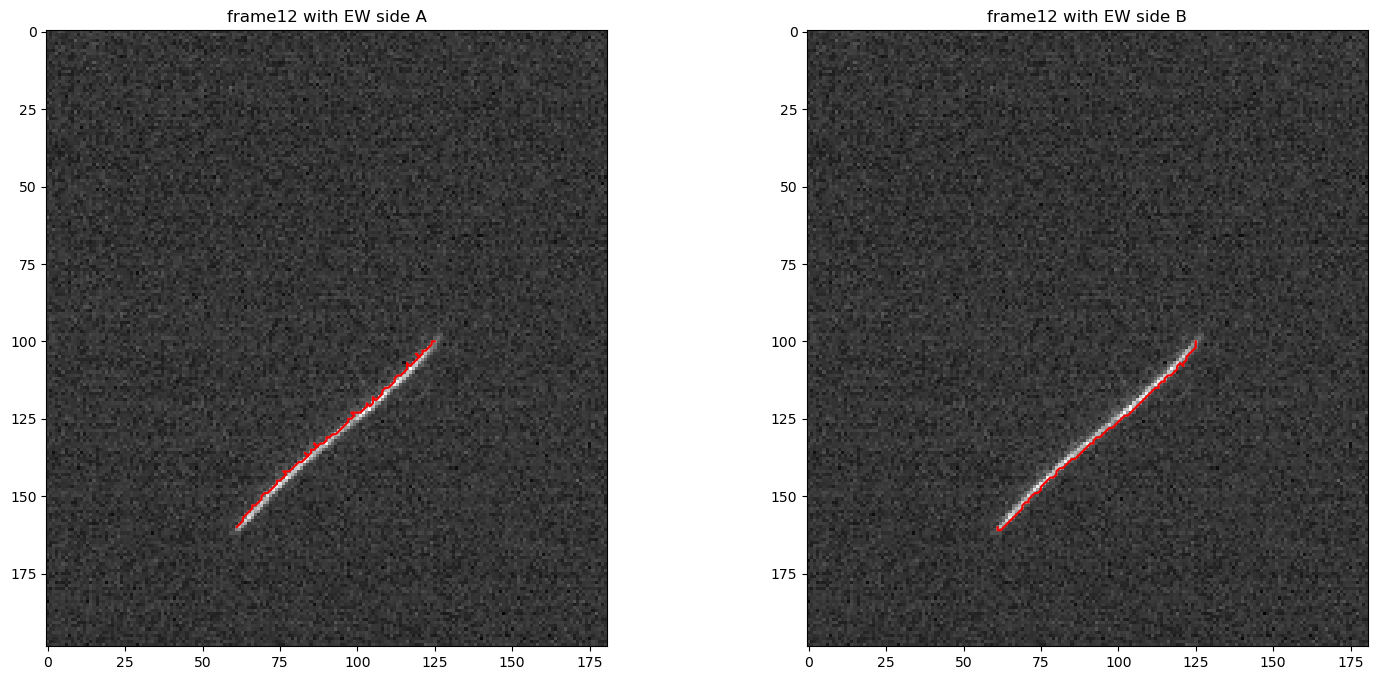

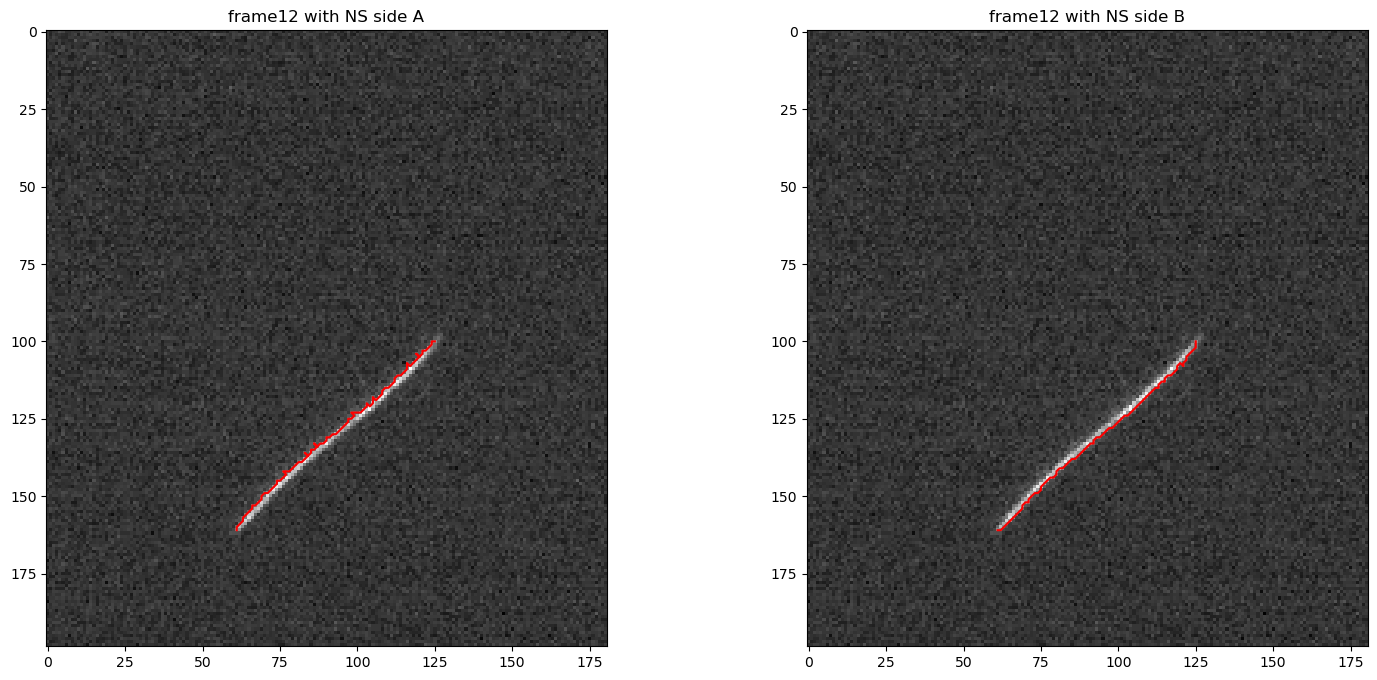

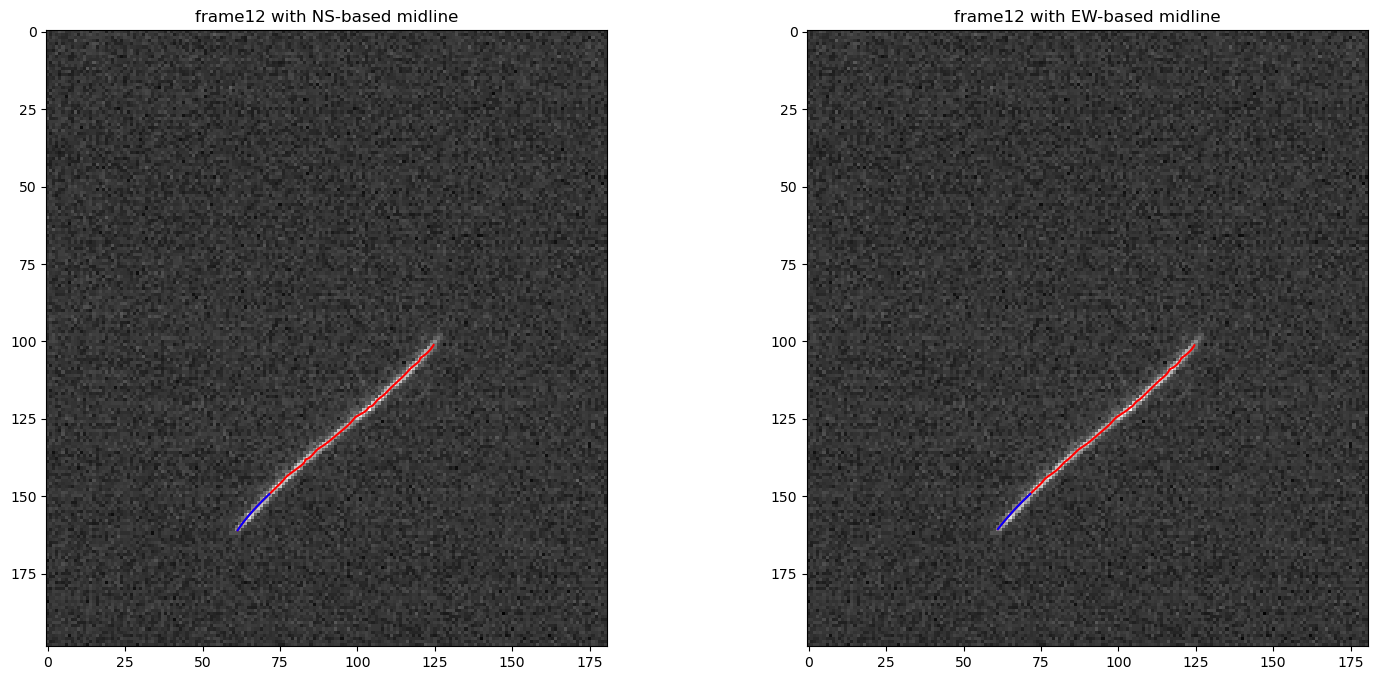

In [12]:
frame=frames[frameid]

#  yen threshold the image
thresh = sk_fil.threshold_yen(frame)  #returns a sensible threshold based on intenstity distribution
binary = frame > (coeffForThresh*thresh)          
frame_thresholded = binary*frame

#find contours in the frame, to get the filament
contours = cv2.findContours(frame_thresholded,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)    #note that this finds all the contours
cnts = imutils.grab_contours(contours)                                                      #get all contours that are found
cnt = max(cnts, key=cv2.contourArea)                                                        #pick the countour with max area - most likely to be our guy
x1 = cnt[:,0,0]                                                                             #x and y coordinates of the contour
y1 = cnt[:,0,1]

#get the extreme ends of the contour
extLeft = tuple(cnt[cnt[:, :, 0].argmin()][0]) #smallest x-coordinate
extRight = tuple(cnt[cnt[:, :, 0].argmax()][0]) #largest x-coordinate
extTop = tuple(cnt[cnt[:, :, 1].argmin()][0]) #smallest y-coordinate
extBot = tuple(cnt[cnt[:, :, 1].argmax()][0]) ##largest y-coordinate
indexforRightCorner, indexforLeftCorner, indexforTopCorner, indexforBottomCorner = dio. get_indicesForCorners_OSS(cnt, extRight, extLeft, extTop, extBot)

xSideA_EW, ySideA_EW, xSideB_EW, ySideB_EW = dio.getMidSplineFromCorners_OSS(x1, y1, indexforLeftCorner, indexforRightCorner)
xSideA_NS, ySideA_NS, xSideB_NS, ySideB_NS = dio.getMidSplineFromCorners_OSS(x1, y1, indexforBottomCorner, indexforTopCorner)

#fit splines to each half side (using both NS and EW orientation results) and create mid-spline. Pick the case with longer filament
filamentLength_EW_inPx = 0
filamentLength_NS_inPx = 0
xn_M_EW, yn_M_EW, midSpline_Ti_EW = [], [], []
xn_M_NS, yn_M_NS, midSpline_Ti_NS = [], [], []
xn_M, yn_M, midSpline_Ti = [], [], []
if (len(xSideA_EW)!=0 and len(xSideB_EW)!=0): 
    xn_M_EW, yn_M_EW, midSpline_Ti_EW = dio.getMidSplineFromContourSides_OSS(xSideA_EW, ySideA_EW, xSideB_EW, ySideB_EW,smooth_spline,k_order_spline,nest)
    filamentLength_EW_inPx = dio.get_filamentLength_OSS(midSpline_Ti_EW)
if (len(xSideA_NS)!=0 and len(xSideB_NS)!=0): 
    xn_M_NS, yn_M_NS, midSpline_Ti_NS = dio.getMidSplineFromContourSides_OSS(xSideA_NS, ySideA_NS, xSideB_NS, ySideB_NS,smooth_spline,k_order_spline,nest)
    filamentLength_NS_inPx = dio.get_filamentLength_OSS(midSpline_Ti_NS)
filamentDist_NS_inPx = np.sqrt((xn_M_NS[0]-xn_M_NS[-1])**2 + (yn_M_NS[0]-yn_M_NS[-1])**2)
filamentDist_EW_inPx = np.sqrt((xn_M_EW[0]-xn_M_EW[-1])**2 + (yn_M_EW[0]-yn_M_EW[-1])**2)
if (filamentDist_NS_inPx > filamentDist_EW_inPx):
    xn_M, yn_M, midSpline_Ti = xn_M_NS, yn_M_NS, midSpline_Ti_NS
else:
    xn_M, yn_M, midSpline_Ti = xn_M_EW, yn_M_EW, midSpline_Ti_EW


#let's see how this looks like: plot the two sides based on EW
fig, ax = plt.subplots(1,2, figsize=(18,8))
ax[0].imshow(frame,cmap="gray")
ax[0].plot(xSideA_EW[:],ySideA_EW[:],color='red') #plotting one side of contour
ax[0].set_title(str('frame'+str(frameid) + ' with EW side A'))
ax[1].imshow(frame,cmap="gray")
ax[1].plot(xSideB_EW[:],ySideB_EW[:],color='red') #plotting one side of contour
ax[1].set_title(str('frame'+str(frameid) + ' with EW side B'))

#let's see how this looks like: plot the two sides based on NS
fig, ax = plt.subplots(1,2, figsize=(18,8))
ax[0].imshow(frame,cmap="gray")
ax[0].plot(xSideA_NS[:],ySideA_NS[:],color='red') #plotting one side of contour
ax[0].set_title(str('frame'+str(frameid) + ' with NS side A'))
ax[1].imshow(frame,cmap="gray")
ax[1].plot(xSideB_NS[:],ySideB_NS[:],color='red') #plotting one side of contour
ax[1].set_title(str('frame'+str(frameid) + ' with NS side B'))

#let's see how this looks like: plot the two sides based on EW
fig, ax = plt.subplots(1,2, figsize=(18,8))
ax[0].imshow(frame,cmap="gray")
ax[0].plot(xn_M_NS[:],yn_M_NS[:],color='red') #plotting one side of contour
ax[0].plot(xn_M_NS[0:100],yn_M_NS[0:100],color='blue') #plotting one side of contour
ax[0].set_title(str('frame'+str(frameid) + ' with NS-based midline'))
ax[1].imshow(frame,cmap="gray")
ax[1].plot(xn_M_EW[:],yn_M_EW[:],color='red') #plotting one side of contour
ax[1].plot(xn_M_EW[0:100],yn_M_EW[0:100],color='blue') #plotting one side of contour
ax[1].set_title(str('frame'+str(frameid) + ' with EW-based midline'))

filamentDist_NS_inPx,filamentDist_EW_inPx, filamentLength_NS_inPx, filamentLength_EW_inPx
#np.where(xn_M_NS==max(xn_M_NS))
#yn_M_NS[500:600]

3. LOOP THROUGH FRAMES, FIT SPLINE TO FILAMENT, IDENTIFY END POINTS AND CALCULATE SPEED, ETC.

In [13]:


#arrays to store the end points of the filament, state of end, 
#and speed, and filament length (spline-based distance between ends)
endA = np.empty(shape=[0, 2])
endB = np.empty(shape=[0, 2])
endA_B_states = np.empty(shape=[0, 2])
endA_B_speeds = np.empty(shape=[0, 2])
filamentLengthPerFrame = np.empty(shape=[0, 1])

#defining some boolean parameters and a counter
trackRecordedA = False
trackRecordedB = False
counter = 0

#main loop through frames of the timalapse
for frame in frames:
    skipFrame = False
    # yen threshold the frame
    thresh = sk_fil.threshold_yen(frame)  #returns a sensible threshold based on intenstity distribution
    binary = frame > (coeffForThresh*thresh)          
    frame_thresholded = binary*frame

    #find contours in the frame, to get the filament
    #NOTE: The function we use returns all contours, but we pick the one with largest area
    #as this is likely to be our filament - given we work with single filament movies
    contours = cv2.findContours(frame_thresholded,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(contours)
    cnt = max(cnts, key=cv2.contourArea)
    x1 = cnt[:,0,0]                         #x and y coordinates of contour
    y1 = cnt[:,0,1]
    
    #get the four extreme points (i.e. corners) of the contour
    extLeft = tuple(cnt[cnt[:, :, 0].argmin()][0]) #smallest x-coordinate
    extRight = tuple(cnt[cnt[:, :, 0].argmax()][0]) #largest x-coordinate
    extTop = tuple(cnt[cnt[:, :, 1].argmin()][0]) #smallest y-coordinate
    extBot = tuple(cnt[cnt[:, :, 1].argmax()][0]) ##largest y-coordinate
    indexforRightCorner, indexforLeftCorner, indexforTopCorner, indexforBottomCorner = dio. get_indicesForCorners_OSS(cnt, extRight, extLeft, extTop, extBot)

    #using the extreme points, get the points making each half of the contour, i.e. each side of the filament
    #do this for both orientations, north-south and east-west
    xSideA_Ti_EW, ySideA_Ti_EW, xSideB_Ti_EW, ySideB_Ti_EW = dio.getMidSplineFromCorners_OSS(x1, y1, indexforLeftCorner, indexforRightCorner)
    xSideA_Ti_NS, ySideA_Ti_NS, xSideB_Ti_NS, ySideB_Ti_NS = dio.getMidSplineFromCorners_OSS(x1, y1, indexforBottomCorner, indexforTopCorner)
    
    #fit splines to each half side (using both NS and EW orientation results) and create mid-spline. 
    filamentLength_EW_inPx = 0
    filamentLength_NS_inPx = 0
    usingEWorientation = False
    usingNSorientation = False
    if (len(xSideA_Ti_NS)!=0 and len(xSideB_Ti_NS)!=0):  
        xn_M_NS, yn_M_NS, midSpline_Ti_NS = dio.getMidSplineFromContourSides_OSS(xSideA_Ti_NS, ySideA_Ti_NS, xSideB_Ti_NS, ySideB_Ti_NS,smooth_spline,k_order_spline,nest)
        filamentLength_NS_inPx = dio.get_filamentLength_OSS(midSpline_Ti_NS)
    if (len(xSideA_Ti_EW)!=0 and len(xSideB_Ti_EW)!=0 and forceUseNS != True): 
        xn_M_EW, yn_M_EW, midSpline_Ti_EW = dio.getMidSplineFromContourSides_OSS(xSideA_Ti_EW, ySideA_Ti_EW, xSideB_Ti_EW, ySideB_Ti_EW,smooth_spline,k_order_spline,nest)
        filamentLength_EW_inPx = dio.get_filamentLength_OSS(midSpline_Ti_EW)

    #decide which orientation to use, based on length of midline. Pick the case with longer filament
    filamentDist_NS_inPx = np.sqrt((xn_M_NS[0]-xn_M_NS[-1])**2 + (yn_M_NS[0]-yn_M_NS[-1])**2)
    filamentDist_EW_inPx = np.sqrt((xn_M_EW[0]-xn_M_EW[-1])**2 + (yn_M_EW[0]-yn_M_EW[-1])**2)

    #manually force using one orientation OR decide automatically
    if (forceUseNS == True):
        xn_M, yn_M, midSpline_Ti = xn_M_NS, yn_M_NS, midSpline_Ti_NS
        filamentLengthThisFrame = filamentLength_NS_inPx*um_per_px        #store filament length as cumulative distance on the mid-point spline. NOTE: we convert pixels to microns at this point.
        usingNSorientation = True
        if (filamentLength_NS_inPx*um_per_px>np.median(filamentLengthPerFrame[0:counter-1])*1.25):   #if well above media of what we have seen so far, flag up
            medLength=np.median(filamentLengthPerFrame[0:counter-1])
            print ('something fishy -  skipping frame: %d, using NS orientation gives filamentLength_NS, EW, median are: %f %f %f' % (counter, filamentLength_NS_inPx*um_per_px, filamentLength_EW_inPx*um_per_px,medLength))
            skipFrame = True
    else:
        if (filamentDist_NS_inPx > filamentDist_EW_inPx):
            xn_M, yn_M, midSpline_Ti = xn_M_NS, yn_M_NS, midSpline_Ti_NS
            filamentLengthThisFrame = filamentLength_NS_inPx*um_per_px        #store filament length as cumulative distance on the mid-point spline. NOTE: we convert pixels to microns at this point.
            usingNSorientation = True
            if (filamentLength_NS_inPx*um_per_px>np.median(filamentLengthPerFrame[0:counter-1])*1.25):   #if well above media of what we have seen so far, flag up
                medLength=np.median(filamentLengthPerFrame[0:counter-1])
                print ('something fishy -  skipping frame: %d, using NS orientation gives filamentLength_NS, EW, median are: %f %f %f' % (counter, filamentLength_NS_inPx*um_per_px, filamentLength_EW_inPx*um_per_px,medLength))
                skipFrame = True
    
        else:
            xn_M, yn_M, midSpline_Ti = xn_M_EW, yn_M_EW, midSpline_Ti_EW
            filamentLengthThisFrame = filamentLength_EW_inPx*um_per_px        #store filament length as cumulative distance on the mid-point spline. NOTE: we convert pixels to microns at this point.
            usingEWorientation = True
            if (filamentLength_EW_inPx*um_per_px>np.median(filamentLengthPerFrame[0:counter-1])*1.25):   #if well above media of what we have seen so far, flag up
                medLength=np.median(filamentLengthPerFrame[0:counter-1])
                print ('something fishy -  skipping frame: %d, using EW orientation gives filamentLength_EW, NS, median are: %f %f %f' % (counter, filamentLength_EW_inPx*um_per_px, filamentLength_NS_inPx*um_per_px,medLength))
                skipFrame = True
           

    if (skipFrame == False):
        filamentLengthPerFrame = np.append(filamentLengthPerFrame,[filamentLengthThisFrame])

    if (usingNSorientation+usingEWorientation==False):
        print ('something fishy in frame: %d, as filamentLength, inPx, estimate are: %d, %f ,' % (counter, forceUseNS, filamentLengthThisFrame))
        print ('length of midlineSpline: %f, %f, %f' % (len(midSpline_Ti),midSpline_Ti[10,0],midSpline_Ti[30,0]))
    if (np.abs(len(xSideA_Ti_NS) + len(xSideB_Ti_NS) - len(x1)) > len(x1)/10 or np.abs(len(xSideA_Ti_EW) + len(xSideB_Ti_EW) - len(x1)) > len(x1)/10):
        print ('something fishy in frame: %d, as contour side lengths, EW, NS are (NS or EW): %f , %f, %f, %f, %d, %d' % (counter, len(xSideA_Ti_NS), len(xSideB_Ti_NS), len(xSideA_Ti_EW), len(xSideB_Ti_EW), usingNSorientation, usingEWorientation))

    #store end points of the mid-point spline:  
    if (skipFrame == False):
        endA = np.append(endA,[[xn_M[0],yn_M[0]]],axis=0)       #we consider 0-end as endA => left or bottom, in red;
        endB = np.append(endB,[[xn_M[-1],yn_M[-1]]],axis=0)     #and -1-end as endB => right or top, in blue

    #if not the first frame, calculate speed of each end point (i.e. filament tip) 
    #NOTE: Speed is simply Euclidian distance between end point from this frame and the previous one
    #NOTE: we convert pixels to micron/sec at this point.
    if counter>0 and skipFrame == False:
        deltaA = np.sqrt((endA[counter,0]-endA[counter-1,0])**2 + (endA[counter,1]-endA[counter-1,1])**2)
        deltaA = (um_per_px/delta_t)*deltaA
        #if (endA[counter,0]-endA[counter-1,0]>0 or endA[counter,1]-endA[counter-1,1]<0): deltaA = -1*deltaA    
        deltaB = np.sqrt((endB[counter,0]-endB[counter-1,0])**2 + (endB[counter,1]-endB[counter-1,1])**2)
        deltaB = (um_per_px/delta_t)*deltaB
        #if (endB[counter,0]-endB[counter-1,0]<0 or endB[counter,1]-endB[counter-1,1]>0): deltaB = -1*deltaB 
        endA_B_speeds = np.append(endA_B_speeds,[[deltaA,deltaB]],axis=0)

    #if not the first frame and endA is not too slow, decide if endA is trailling or leading
    #we make this decision based on angles of displacement and "filament direction" vectors
    #and using this for vector angle calculation:
    #https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python
    if counter>0 and skipFrame == False:
        if np.abs(deltaA)>speedthreshold_headTail_trackPoint:
            p0_A = [endA[counter-1,0], endA[counter-1,1]] #this point is endA from previous frame
            p1_A = [endA[counter,0], endA[counter,1]]     #this point is endA from this frame
            p2_A = [xn_M[10], yn_M[10]]                     #this point is 10 spline points from endA (from this frame) towards the inside of the filament 
            v0_A = np.array(p1_A) - np.array(p0_A)            #this is the vector for displacement of endA between frames
            v1_A = np.array(p1_A) - np.array(p2_A)            #this is the vector pointg from inside the filament towards the outside (at the endA)
            angle_A = math.atan2(np.linalg.det([v0_A,v1_A]),np.dot(v0_A,v1_A))     #this is the angle between the "displacement" and "from filament to outside" vectors
            angle_A = np.degrees(angle_A)
            if np.abs(angle_A)>90: 
                stateA = 0              #negative angle indicates endA is trailling (0).
            else:                        
                stateA = 1              #positive angle indicates endA is leading (1).
        else:
            stateA = -1                             #if too slow, just call it undecided, use -1
        
        if np.abs(deltaB)>speedthreshold_headTail_trackPoint:
            p0_B = [endB[counter-1,0], endB[counter-1,1]] #this point is endB from previous frame
            p1_B = [endB[counter,0], endB[counter,1]]     #this point is endB from this frame
            p2_B = [xn_M[-10], yn_M[-10]]                     #this point is 10 spline points from endB (from this frame) towards the inside of the filament 
            v0_B = np.array(p1_B) - np.array(p0_B)            #this is the vector for displacement of endB between frames
            v1_B = np.array(p1_B) - np.array(p2_B)            #this is the vector pointg from inside the filament towards the outside (at the endB)
            angle_B = math.atan2(np.linalg.det([v0_B,v1_B]),np.dot(v0_B,v1_B))     #this is the angle between the "displacement" and "from filament to outside" vectors
            angle_B = np.degrees(angle_B)
            if np.abs(angle_B)>90: 
                stateB = 0              #negative angle indicates endB is trailling (0). 
            else: 
                stateB = 1              #positive angle indicates endB is leading (1).
        else:
            stateB = -1                    #if too slow, just call it undecided, use -1    
        endA_B_states = np.append(endA_B_states,[[stateA,stateB]],axis=0)    

 #   if counter>0: print ('debug: %d, %f, %f, %f, %f, %f, %f, %f, %f' % (counter, filamentLength_NS_inPx, filamentLength_EW_inPx,angle_A,angle_B,v1_B[0],v1_B[1],v0_B[0],v0_B[1]))       
    if (skipFrame == False):
        counter += 1  

#insert the state and speed of first frame, based on 2nd frame
endA_B_states = np.insert(endA_B_states,0,[[endA_B_states[0,0],endA_B_states[0,1]]],axis=0)   
endA_B_speeds = np.insert(endA_B_speeds,0,[[endA_B_speeds[0,0],endA_B_speeds[0,1]]],axis=0)
      

#Next lines are just printing out stuff for debugging
#endA_B_states[30:60,:]
#endA_B_speeds[30:35,:]
#endA[29:35,:]
#len(endA_B_states)-len(endA_B_speeds)
#endB

/opt/anaconda3/envs/ossEnv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/ossEnv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4. CREATE ARRAYS FOR 1D END POINT POSITION, SPEED, AND TIME. MAKE SMOOTH VERSIONS TOO

In [14]:

#calculate an x-axis data
time_pts_sec = np.arange(0, len(endA_B_speeds),1)*delta_t           #create a time array based on time interval of frames and smooth it
time_smooth = savgol_filter(time_pts_sec, howsmooth, poly_order)

#convert 2d position data (of end points) into 1d data by calculating endpoint 
#distance to a specific point (which is picked in the code above)
posA = np.zeros(len(endA))
posB = np.zeros(len(endB))
for i in range(0,len(endA)):
    posA[i] = um_per_px*np.sqrt((endA[i,0]-trackEndPointA[0])**2 + (endA[i,1]-trackEndPointA[1])**2)
for i in range(0,len(endB)):
    posB[i] = um_per_px*np.sqrt((endB[i,0]-trackEndPointB[0])**2 + (endB[i,1]-trackEndPointB[1])**2)

#create smoothed versions of position array
posA_smooth = savgol_filter(posA, howsmooth, poly_order)
posB_smooth = savgol_filter(posB, howsmooth, poly_order)

#create smoothed versions of speed array - this is speed, as calculated above from frame-wise distances
#speedA_fromFrames_smooth = savgol_filter(endA_B_speeds[:,0], howsmooth, poly_order)
#speedB_fromFrames_smooth = savgol_filter(endA_B_speeds[:,1], howsmooth, poly_order)

#calculate endpoint speeds using smoothed position data
speedA_smooth = np.gradient(posA_smooth)/delta_t
speedB_smooth = np.gradient(posB_smooth)/delta_t

#create smoothed versions of speed array - this is speed, as calculated here from smoothed position data
speedA_smooth2 = savgol_filter(speedA_smooth, howsmooth, poly_order)
speedB_smooth2 = savgol_filter(speedB_smooth, howsmooth, poly_order)

#normalise position data - after using it for speed calc
posA_norm = posA / max(posA)
posB_norm = posB / max(posB)
posA_smooth_norm = posA_smooth / max(posA_smooth)
posB_smooth_norm = posB_smooth / max(posB_smooth)

#display max speed - to be inserted above (see parameter section) as analysis parameter
max(max(speedA_smooth2),max(speedB_smooth2))


0.757224419144603

Text(0.5, 0, 'Time [sec]')

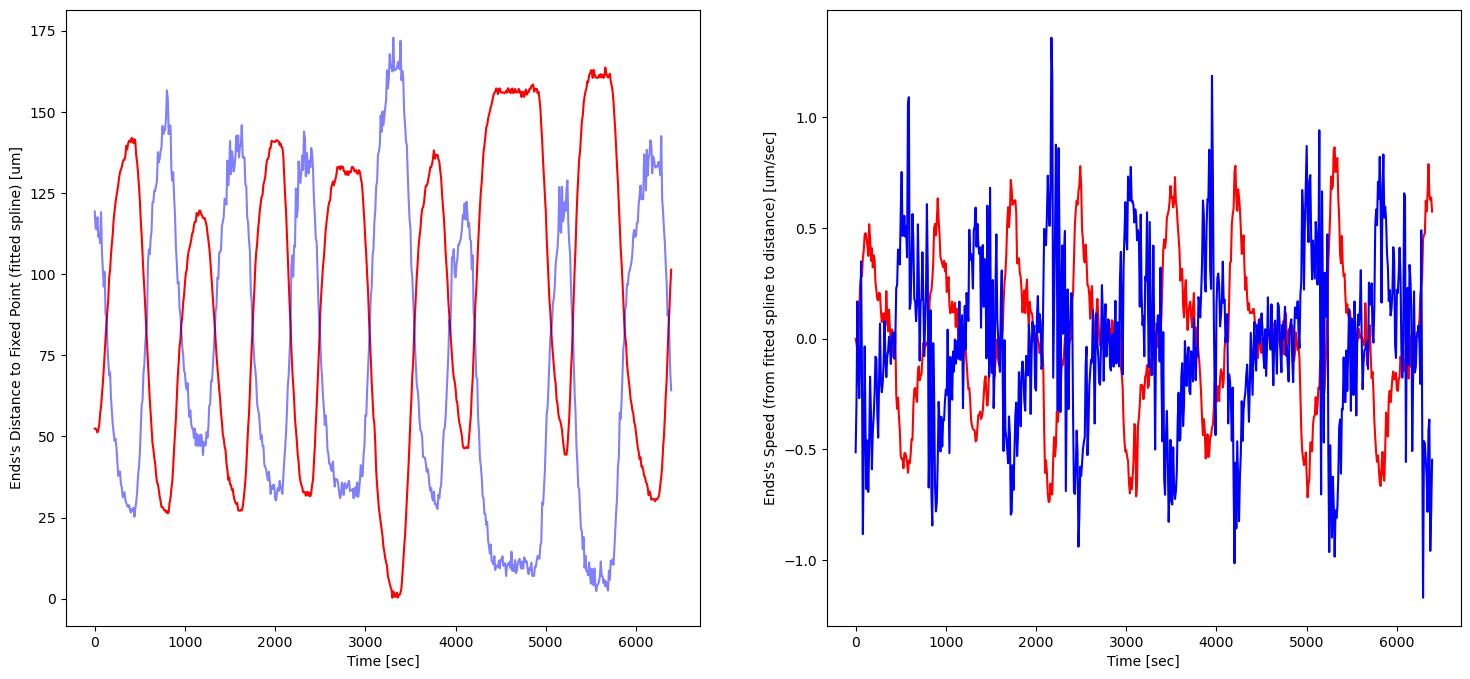

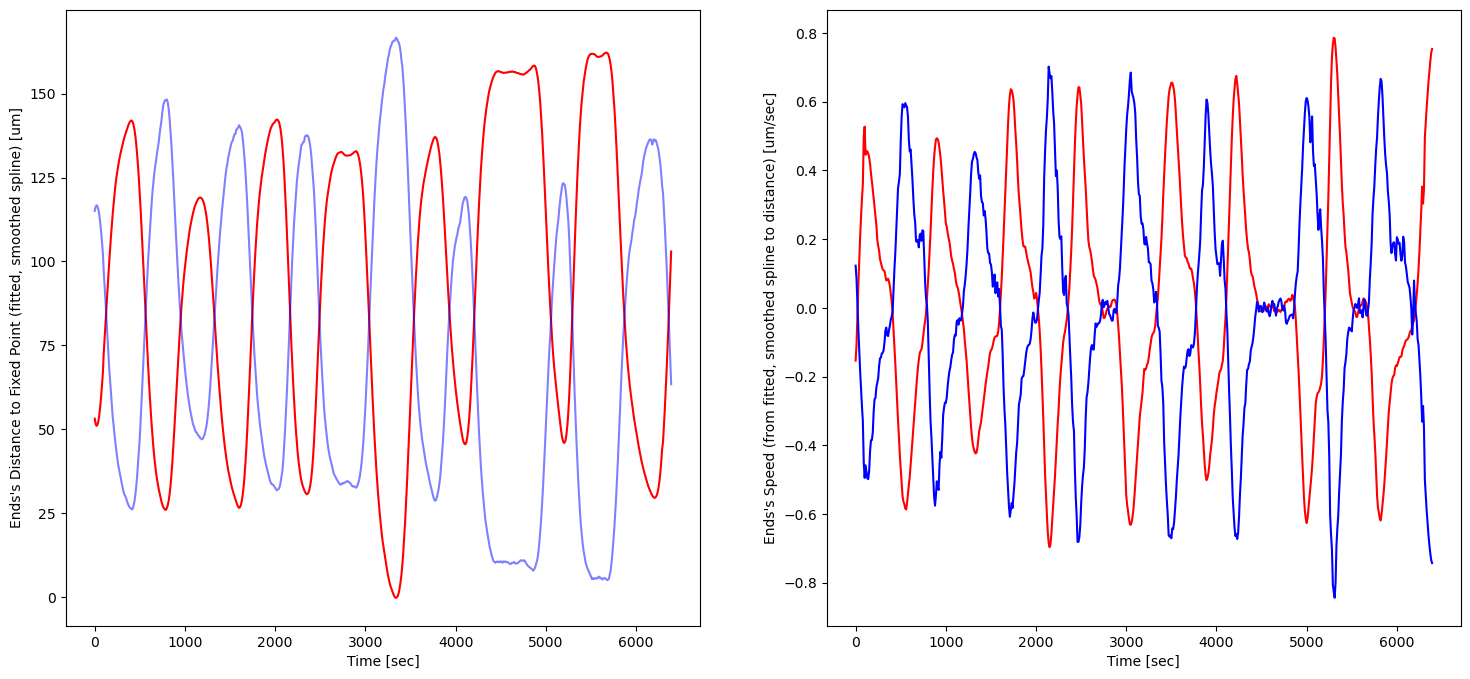

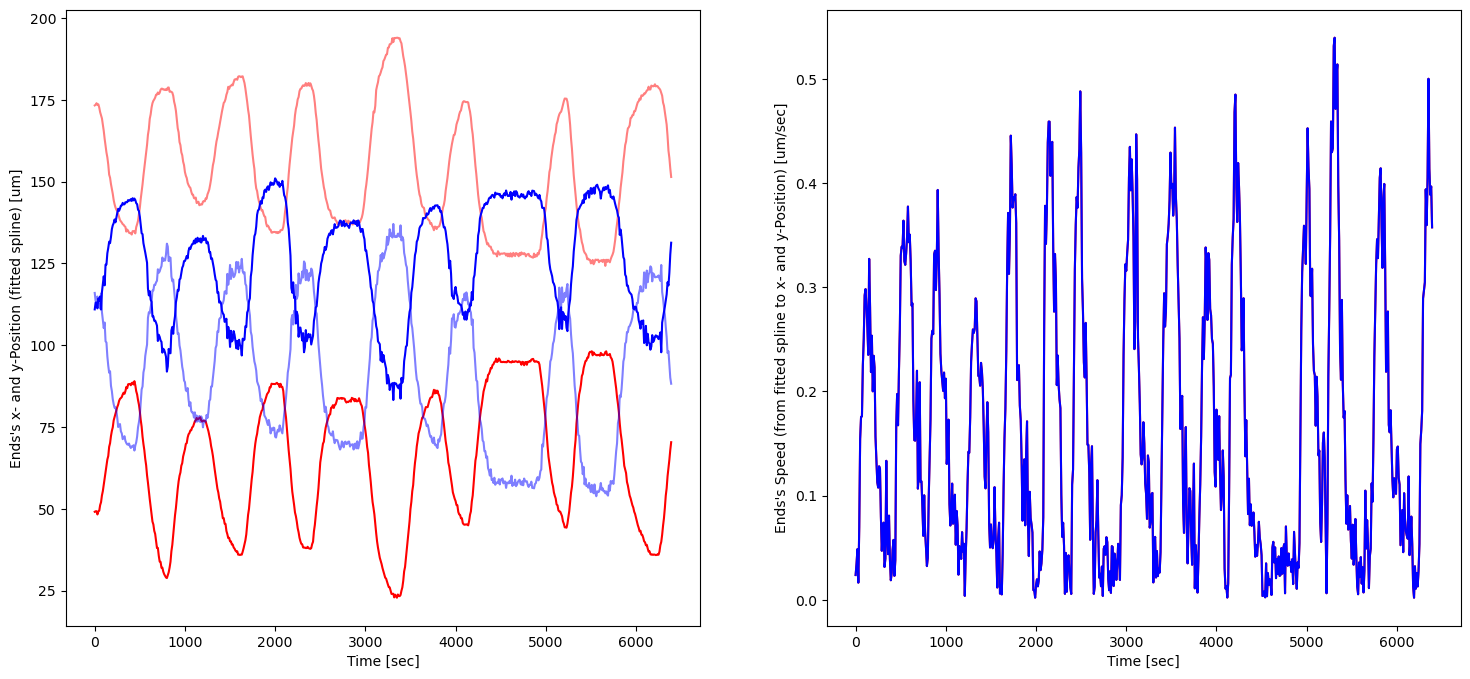

In [15]:
#### APPROACH WITH SPLINE FITTING ###
### NOT USED - JUST FOR TRIAL - PRODUCES SAME/SIMILAR RESULTS ####

import scipy.interpolate as interpolate

#taking Marco approach of spline fitting 
#spline fit posA data (distance for endA)
t, c, k = interpolate.splrep(time_pts_sec,posA, s=0, k=4)
spline_posA = interpolate.BSpline(t, c, k, extrapolate=False)
#spline fit posB data (distance for endB)
t, c, k = interpolate.splrep(time_pts_sec,posB, s=0, k=4)
spline_posB = interpolate.BSpline(t, c, k, extrapolate=False)
#get speed (in um/sec) from spline fits
vA = np.gradient(spline_posA(time_pts_sec))/delta_t
vB = np.gradient(spline_posB(time_pts_sec))/delta_t

#plot spline fit for position and speed resulting from it
fig, ax = plt.subplots(1,2, figsize=(18,8))
ax[0].plot(time_pts_sec, spline_posA(time_pts_sec), 'r', label='BSpline')
ax[0].plot(time_pts_sec, spline_posB(time_pts_sec), 'b', alpha=0.5,label='BSpline')
ax[0].set_ylabel('Ends\'s Distance to Fixed Point (fitted spline) [um]')
ax[0].set_xlabel('Time [sec]')
ax[1].plot(time_pts_sec,vA,'r')
ax[1].plot(time_pts_sec,vB,'b')
ax[1].set_ylabel('Ends\'s Speed (from fitted spline to distance) [um/sec]')
ax[1].set_xlabel('Time [sec]')

#re-plot, but this time get speed from smoothed spline fits for position data
posA_smooth_marco = savgol_filter(spline_posA(time_pts_sec), howsmooth, poly_order)
posB_smooth_marco = savgol_filter(spline_posB(time_pts_sec), howsmooth, poly_order)
vA_smooth = np.gradient(posA_smooth_marco)/delta_t
vB_smooth = np.gradient(posB_smooth_marco)/delta_t
fig, ax = plt.subplots(1,2, figsize=(18,8))
ax[0].plot(time_pts_sec, posA_smooth_marco, 'r', label='BSpline')
ax[0].plot(time_pts_sec, posB_smooth_marco, 'b', alpha=0.5,label='BSpline')
ax[0].set_ylabel('Ends\'s Distance to Fixed Point (fitted, smoothed spline) [um]')
ax[0].set_xlabel('Time [sec]')
ax[1].plot(time_pts_sec,vA_smooth,'r')
ax[1].plot(time_pts_sec,vB_smooth,'b')
ax[1].set_ylabel('Ends\'s Speed (from fitted, smoothed spline to distance) [um/sec]')
ax[1].set_xlabel('Time [sec]')

#spline fit endA data, x and y coordinates
t, c, k = interpolate.splrep(time_pts_sec,endA[:,0], s=0, k=4)
splineA_x = interpolate.BSpline(t, c, k, extrapolate=False)
t, c, k = interpolate.splrep(time_pts_sec,endA[:,1], s=0, k=4)
splineA_y = interpolate.BSpline(t, c, k, extrapolate=False)
#spline fit endB data, x and y coordinates
t, c, k = interpolate.splrep(time_pts_sec,endB[:,0], s=0, k=4)
splineB_x = interpolate.BSpline(t, c, k, extrapolate=False)
t, c, k = interpolate.splrep(time_pts_sec,endB[:,1], s=0, k=4)
splineB_y = interpolate.BSpline(t, c, k, extrapolate=False)
#calculate speed from x- and y- coordinates' spline fit
vA_x = np.gradient(splineA_x(time_pts_sec))/delta_t
vA_y = np.gradient(splineA_y(time_pts_sec))/delta_t
vA = np.sqrt(vA_x**2+vA_y**2)
vB_x = np.gradient(splineB_x(time_pts_sec))/delta_t
vB_y = np.gradient(splineB_y(time_pts_sec))/delta_t
vB = np.sqrt(vB_x**2+vB_y**2)
#plot
fig, ax = plt.subplots(1,2, figsize=(18,8))
ax[0].plot(time_pts_sec, splineA_x(time_pts_sec), 'r', label='BSpline')
ax[0].plot(time_pts_sec, splineA_y(time_pts_sec), 'r', alpha=0.5,label='BSpline')
ax[0].plot(time_pts_sec, splineB_x(time_pts_sec), 'b', label='BSpline')
ax[0].plot(time_pts_sec, splineB_y(time_pts_sec), 'b', alpha=0.5,label='BSpline')
ax[0].set_ylabel('Ends\'s x- and y-Position (fitted spline) [um]')
ax[0].set_xlabel('Time [sec]')
ax[1].plot(time_pts_sec,vA,'r')
ax[1].plot(time_pts_sec,vA,'b')
ax[1].set_ylabel('Ends\'s Speed (from fitted spline to x- and y-Position) [um/sec]')
ax[1].set_xlabel('Time [sec]')


5. EXTEND HEAD/TAIL ASSIGNMENTS AND CREATE COLOR INFO BASED ON THEM (FOR PLOTTING)

In [17]:
#tidy up end point states: extend head/tail assignments backwards/forwards across the filament

#first copy original state assignment array
endA_B_states2 = np.copy(endA_B_states)

#find the points where head/tail assignment was clear, and get the first one
dum=np.where(endA_B_states[:,0]+endA_B_states[:,1]==1)  
firstClear = min(dum[0])      

#go backwards from the first point of clear assignment
#and carry over assignment, disregarding existing assignment (which is undecided)                          
for i in range(0,firstClear):                    
    endA_B_states2[i,0] = endA_B_states[firstClear,0]
    endA_B_states2[i,1] = endA_B_states[firstClear,1]

#go forwards from the first point of clear assignment
#and carry over assignment, considering also what the next assignment was
for i in range(firstClear,len(endA_B_states)-1):        
    currentStateA = endA_B_states2[i,0]
    currentStateB = endA_B_states2[i,1]
    nextStateA = endA_B_states[i+1,0]
    nextStateB = endA_B_states[i+1,1]
    if (nextStateA + nextStateB == -2):         #if both states became undecided
        endA_B_states2[i+1,0] = currentStateA   #carry over current states
        endA_B_states2[i+1,1] = currentStateB
    else:
        if (nextStateA == -1 and nextStateB==currentStateB):    #if A became undecided and B stayed the same
            endA_B_states2[i+1,0] = currentStateA               #carry forward A
        if (nextStateA == -1 and nextStateB!=currentStateB):    #if A became undecided and B swapped
            endA_B_states2[i+1,0] = currentStateB               #swap A as well
        if (nextStateB == -1 and nextStateA==currentStateA):    #if B became undecided and A stayed the same
            endA_B_states2[i+1,1] = currentStateB               #carry forward B
        if (nextStateB == -1 and nextStateA!=currentStateA):    #if B became undecided and A swapped
            endA_B_states2[i+1,1] = currentStateA               #swap B as well
    
endA_B_states2[len(endA_B_states)-1,:] = endA_B_states2[len(endA_B_states)-2,:]         #carry over last assignment

#create colors (and pointer size) based on state of ends, trailling (black) or leading (red or blue)
mycolorsA = np.empty(shape=[0, 3])
mySA = np.empty(shape=[0, 1])
mycolorsB = np.empty(shape=[0, 3])
mySB = np.empty(shape=[0, 1])
for i in range(0,len(endA_B_states2)):
   if endA_B_states2[i,0] != -1:
        mycolorsA = np.append(mycolorsA,([[1,1-endA_B_states2[i,0],1-endA_B_states2[i,0]]]),axis=0)
        mySA = np.append(mySA,([[endA_B_states2[i,0]]]),axis=0)
   if endA_B_states2[i,1] != -1:
        mycolorsB = np.append(mycolorsB,([[1-endA_B_states2[i,1], 1-endA_B_states2[i,1],1]]),axis=0)
        mySB = np.append(mySB,([[endA_B_states2[i,1]]]),axis=0)

#endA_B_states2

6. PLOT EXAMPLE FRAME, AND POSITION, SPEED, AND FILAMENT LENGTH FROM TIMELAPSE

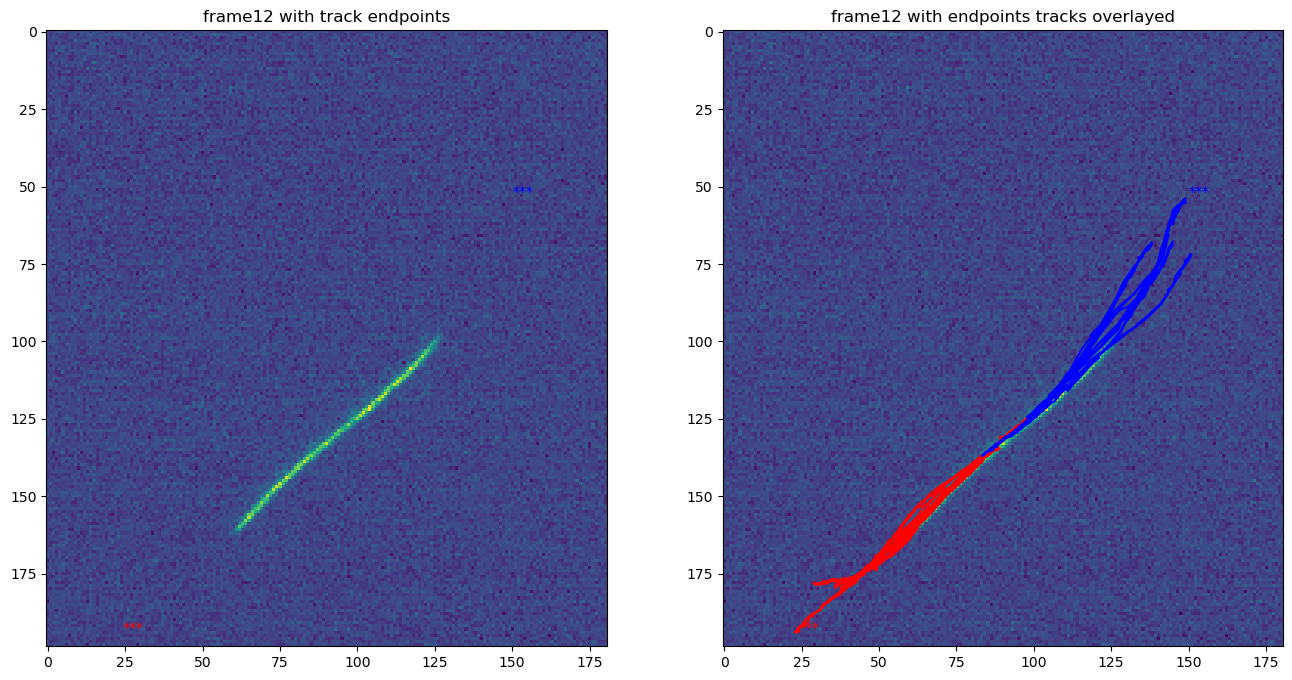

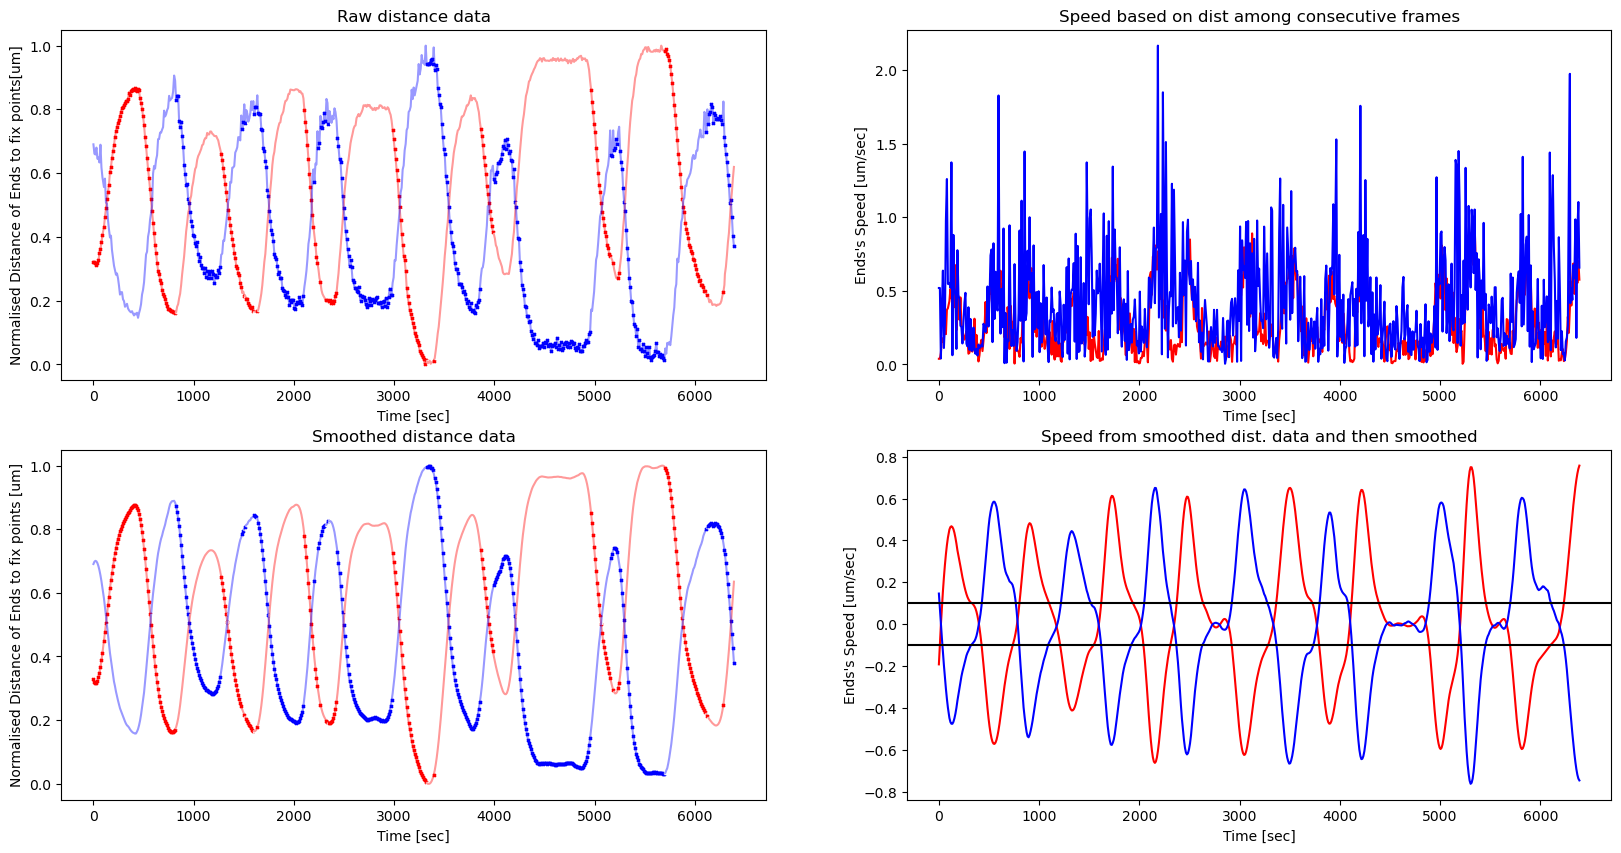

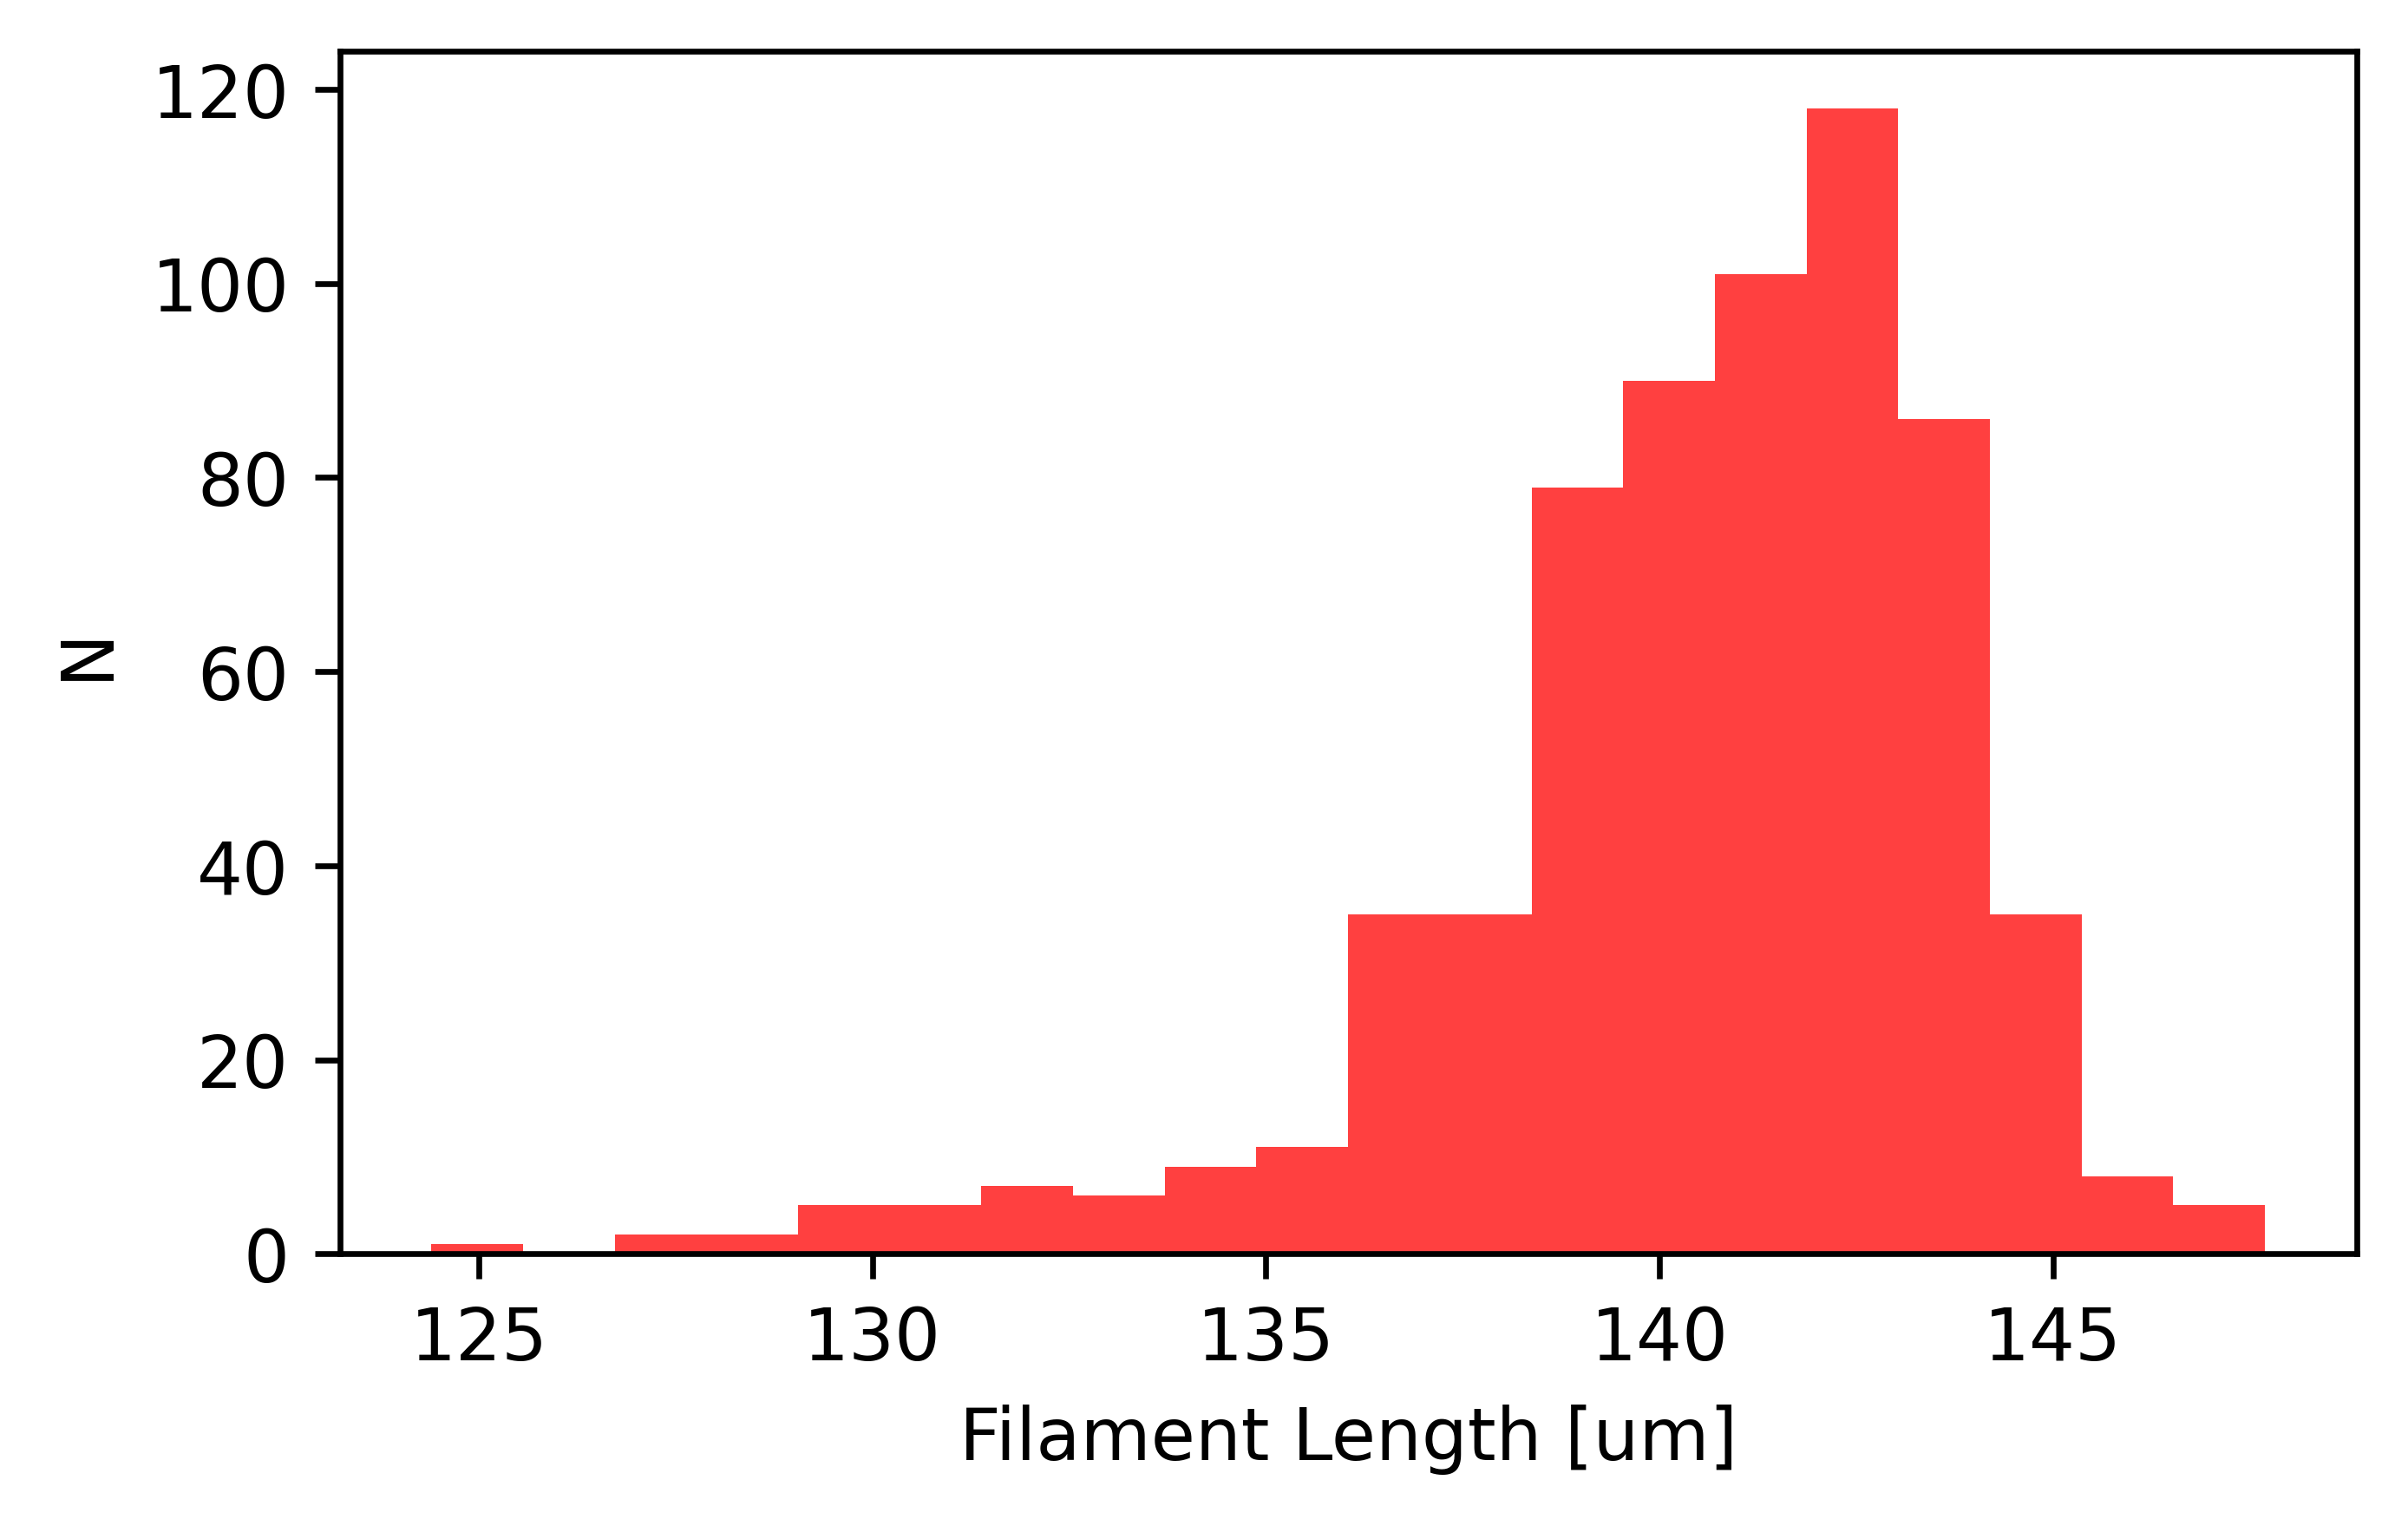

In [18]:

#plot filament with filament ends painted  
frame=frames[frameid] 
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].imshow(frame)
ax[0].annotate('***',xy=(trackEndPointA[0],trackEndPointA[1]),color='red')  #marking ends based on order of spline points
ax[0].annotate('***',xy=(trackEndPointB[0],trackEndPointB[1]),color='blue')
ax[0].set_title(str('frame'+str(frameid) + ' with track endpoints'))
ax[1].imshow(frame)
ax[1].plot(endA[:,0],endA[:,1],color='red')
ax[1].plot(endB[:,0],endB[:,1],color='blue')
ax[1].annotate('***',xy=(trackEndPointA[0],trackEndPointA[1]),color='red')  #marking ends based on order of spline points
ax[1].annotate('***',xy=(trackEndPointB[0],trackEndPointB[1]),color='blue')
ax[1].set_title(str('frame'+str(frameid) + ' with endpoints tracks overlayed'))

fig.savefig(saveFile_image)
plt.show()
plt.close(fig)

#plot position and speed
#plot filament end point positions w.r.t a fixed point and indicating their state
#raw and smooth versions
fig, ax = plt.subplots(2,2, figsize=(20,10))
for i in range(0,len(time_smooth)):
    ax[0,0].scatter(time_smooth[i],posA_norm[i],s=mySA[i]+3,color=mycolorsA[i],marker='x')
    ax[0,0].scatter(time_smooth[i],posB_norm[i],s=mySB[i]+3,color=mycolorsB[i],marker='x')
ax[0,0].plot(time_smooth,posA_norm,'-',color='red',alpha=0.4)
ax[0,0].plot(time_smooth,posB_norm,'-',color='blue',alpha=0.4)
ax[0,0].set_ylabel('Normalised Distance of Ends to fix points[um]')
ax[0,0].set_xlabel('Time [sec]')
ax[0,0].set_title(str('Raw distance data'))

for i in range(0,len(time_smooth)):
    ax[1,0].scatter(time_smooth[i],posA_smooth_norm[i],s=mySA[i]+3,color=mycolorsA[i],marker='x')
    ax[1,0].scatter(time_smooth[i],posB_smooth_norm[i],s=mySB[i]+3,color=mycolorsB[i],marker='x')
ax[1,0].plot(time_smooth,posA_smooth_norm,'-',color='red',alpha=0.4)
ax[1,0].plot(time_smooth,posB_smooth_norm,'-',color='blue',alpha=0.4)
ax[1,0].set_ylabel('Normalised Distance of Ends to fix points [um]')
ax[1,0].set_xlabel('Time [sec]')
ax[1,0].set_title(str('Smoothed distance data'))

#plot filament speed (raw and smooth)
ax[0,1].plot(time_smooth,endA_B_speeds[:,0],'-',color='red')
ax[0,1].plot(time_smooth,endA_B_speeds[:,1],'-',color='blue')
ax[0,1].set_ylabel('Ends\'s Speed [um/sec]')
ax[0,1].set_xlabel('Time [sec]')
ax[0,1].set_title(str('Speed based on dist among consecutive frames'))

ax[1,1].plot(time_smooth,speedA_smooth2,'-',color='red')
ax[1,1].plot(time_smooth,speedB_smooth2,'-',color='blue')
ax[1,1].axhline(y=speedThreshold_DwellTime, color='black', linestyle='-')
ax[1,1].axhline(y=-1*speedThreshold_DwellTime, color='black', linestyle='-')
ax[1,1].set_ylabel('Ends\'s Speed [um/sec]')
ax[1,1].set_xlabel('Time [sec]')
ax[1,1].set_title(str('Speed from smoothed dist. data and then smoothed'))

fig.savefig(saveFile_pos_Speed)
plt.show()
plt.close(fig)

#plot filament length from each frame as histogram - to make sure there is low variance
fig, ax = plt.subplots(1,1, figsize=(5,3), dpi=600)
ax.hist(filamentLengthPerFrame,bins=20, density=False, alpha=0.75, color='red')
ax.set_ylabel('N')
ax.set_xlabel('Filament Length [um]')

fig.savefig(saveFilamentLength)
plt.show()
plt.close(fig)

7. DWELL TIME CALCULATION USING SPEED BASED ON FILAMENT ENDS' ACTUAL LOCATION

In [19]:
#calculating stop duration during each reversal using speed data from above

#create an array to hold cases where we have clear head/tail assignment
dum=np.where(endA_B_states2[:,0]+endA_B_states2[:,1]==1)[0]  #points where head/tail assignment was clear. #because np.where returns a tuple, we need the [0] bit

#create an array to hold and indication where speed was below threshold 
dumb1 = np.zeros(len(speedA_smooth2))
dumb1[np.where(abs(speedA_smooth2)<speedThreshold_DwellTime)]=1 
dumb2 = np.zeros(len(speedB_smooth2))
dumb2[np.where(abs(speedB_smooth2)<speedThreshold_DwellTime)]=1

#define some parameters to use in the processing and start processing speed data
k1 = 0
stopDurationsA = np.empty(shape=[0, 6])
startTime1 = 0
startPause1 = 0
pointHeadTail = 0
for counter in range(0,len(dumb1)):
    if (dumb1[counter]==1):                     #location where endA speed was below threshold
        if startPause1 == 0:                    #first time we are here, so record this as beginning of stop
            startTime1 =  time_smooth[counter]
            #go back from this time to first clear head/tail assignment
            if (counter>0): 
                dumber=np.where(dum[0]<counter)[0] #get the timepoints (smaller than 'counter') where head/tail was clear. #because np.where returns a tuple, we need the [0] bit
                pointHeadTail = dum[max(dumber)]  #get the maximum among those timepoints, i.e. the closest point to 'counter'
            stopType = endA_B_states2[pointHeadTail,0]        #record state of endA at that point 
        startPause1 = startPause1 + 1           #counter for how many steps we were stopped
    if (dumb1[counter]==0) and startPause1>0:   #location where speed was above threshold and we have just been in a stop previously
        endTime1 = time_smooth[counter-1]             #record the previous point as end of stop.
        startPause1=0                           #set counter for stopping steps back to zero for next stop and record data
        stopDurationsA = np.append(stopDurationsA, [[k1,endTime1-startTime1,startTime1,endTime1,stopType,np.mean(filamentLengthPerFrame)]], axis=0)
        k1=k1+1

stopDurationsB = np.empty(shape=[0, 6])
k2 = 0
startTime2 = 0
startPause2=0
pointHeadTail = 0
for counter in range(0,len(dumb2)):
    if (dumb2[counter]==1):                     #location where speed of endB was below threshold
        if startPause2 == 0:                    #first time we are here, so record this as beginning of stop
            startTime2 =  time_smooth[counter]
            #go back from this time to first clear head/tail assignment
            if (counter>0): 
                dumber=np.where(dum[0]<counter)[0]      #because np.where returns a tuple, we need the [0] bit
                pointHeadTail = dum[max(dumber)]
            stopType = endA_B_states2[pointHeadTail,1]            #record state of endB at that point
        startPause2 = startPause2 + 1               #counter for how many steps we were stopped
    if (dumb2[counter]==0) and startPause2>0:       #location where speed was above threshold and we have just been in a stop previously
        endTime2 = time_smooth[counter-1]                         #record the previous point as end of stop.
        startPause2=0                               #set counter for stopping steps back to zero for next stop and record data
        stopDurationsB = np.append(stopDurationsB, [[k2,endTime2-startTime2,startTime2,endTime2,stopType, np.mean(filamentLengthPerFrame)]], axis=0)
        k2=k2+1

stopDurations = np.concatenate((stopDurationsA, stopDurationsB))
len(stopDurations)

/var/folders/gv/q0hyps757tjd5c_j0dwtgghc0000gq/T/ipykernel_31200/1993321345.py:24: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  dumber=np.where(dum[0]<counter)[0] #get the timepoints (smaller than 'counter') where head/tail was clear. #because np.where returns a tuple, we need the [0] bit
/var/folders/gv/q0hyps757tjd5c_j0dwtgghc0000gq/T/ipykernel_31200/1993321345.py:45: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  dumber=np.where(dum[0]<counter)[0]      #because np.where returns a tuple, we need the [0] bit


30

8. PLOTTING DWELL TIME FOR EACH END AND FOR TAILS AND HEADS

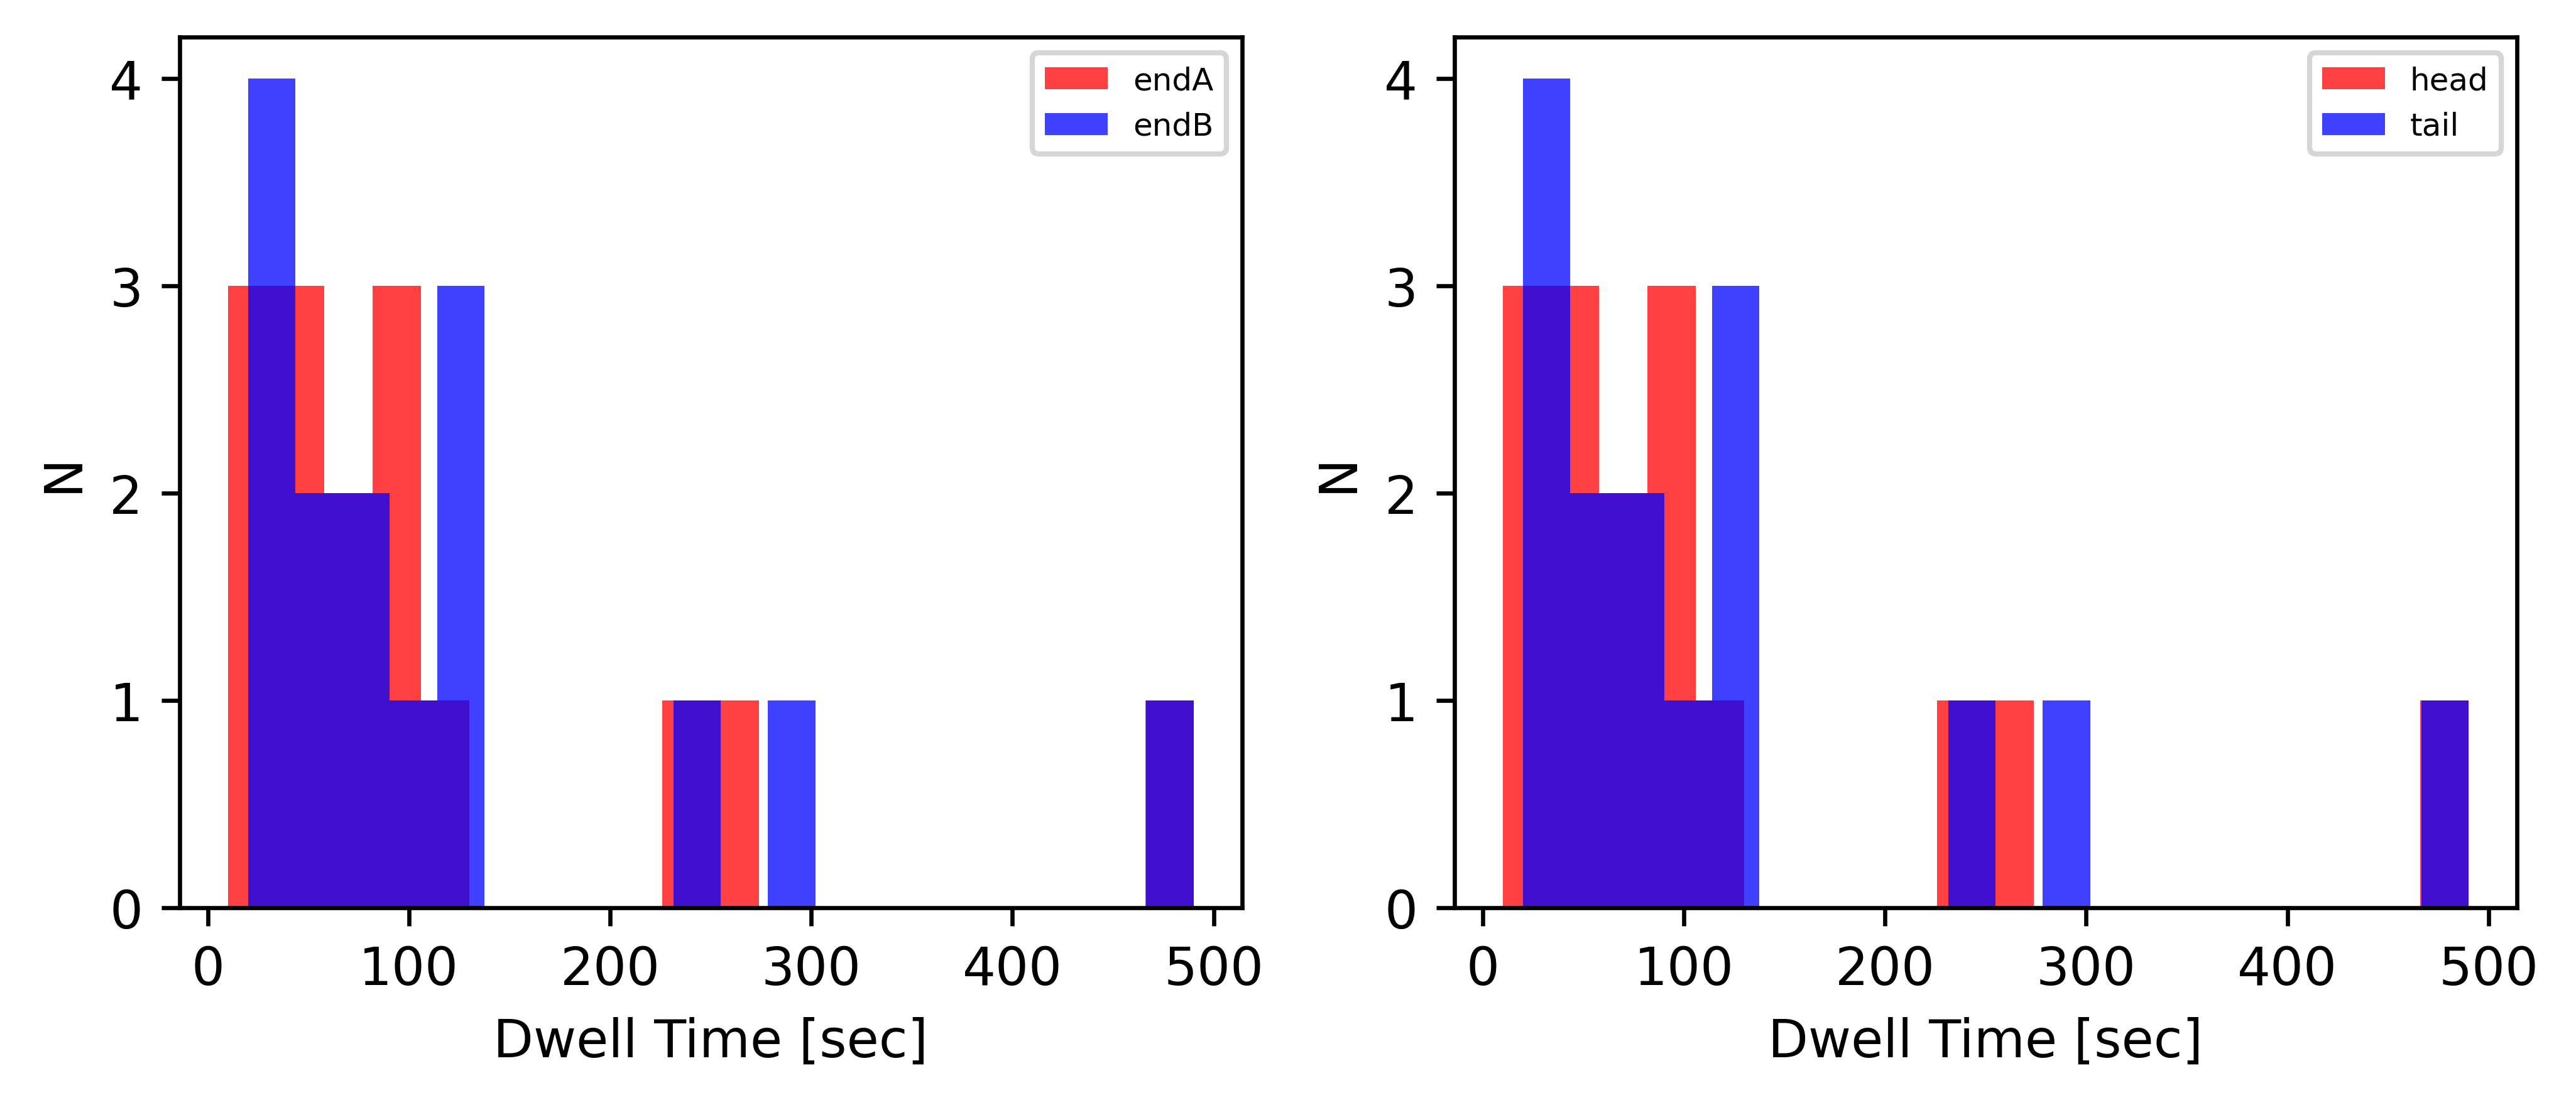

In [20]:
#pick the data for head and tail seperately
maskHead = (stopDurations[:, 4] == 1)
stopDurationsHead = stopDurations[maskHead, :]
maskTail = (stopDurations[:, 4] == 0)
stopDurationsTail = stopDurations[maskTail, :]

#plot dwell times as histograms, seperating head and tail or the two ends
fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=600)
ax[0].hist(stopDurationsA[:,1],bins=20, density=False, alpha=0.75, color='red', label='endA')
ax[0].hist(stopDurationsB[:,1],bins=20, density=False, alpha=0.75, color='blue',label='endB')
ax[0].set_ylabel('N')
ax[0].set_xlabel('Dwell Time [sec]')
ax[0].legend(loc="upper right",fontsize=6)

ax[1].hist(stopDurationsHead[:,1],bins=20, density=False, alpha=0.75, color='red', label='head')
ax[1].hist(stopDurationsTail[:,1],bins=20, density=False, alpha=0.75, color='blue',label='tail')
ax[1].set_ylabel('N')
ax[1].set_xlabel('Dwell Time [sec]')
ax[1].legend(loc="upper right",fontsize=6)

fig.savefig(saveFileHist)
plt.show()
plt.close(fig)


9. PUT THE DATA IN A FILE AND SAVE

In [21]:
# Prepare the results table
import pandas as pd
result_dict = { 'path to data': path, 'Speed Threshold Used' : speedThreshold_DwellTime, 'Pixel Size Used' : um_per_px, 
               'Delta t Used' : delta_t, 'Mean Filament length[um]': stopDurations[:,5], 'stopID' : stopDurations[:,0], 
               'dwell_time [sec]' : stopDurations[:,1], 'startTime' : stopDurations[:,2], 'endTime' : stopDurations[:,3], 
               'Head|Tail' :stopDurations[:,4], 'umPerPx' : um_per_px, 'deltaT' : delta_t, 'coeffForThresh' : coeffForThresh,
               'smoothSpline' : smooth_spline, 'kOrderSpline' : k_order_spline,
               'speedthreshold_headTail_trackPoint' : speedthreshold_headTail_trackPoint,
               'howsmooth' : howsmooth, 'poly_order' : poly_order, 'speedThreshold_DwellTime' : speedThreshold_DwellTime}
result = pd.DataFrame.from_dict(result_dict)
result.head()

# ------------------ SAVE ---------------- #
result.to_csv(saveMyData, sep=',')